In [ ]:
pip install pandas neo4j

In [ ]:
!pip install tensorflow==2.11.0

In [ ]:
!pip install node2vec

In [ ]:
!pip install git+https://github.com/VenkateshwaranB/stellargraph.git


  Cloning https://github.com/VenkateshwaranB/stellargraph.git to /tmp/pip-req-build-tcz97ls5
  Running command git clone --filter=blob:none --quiet https://github.com/VenkateshwaranB/stellargraph.git /tmp/pip-req-build-tcz97ls5
  Resolved https://github.com/VenkateshwaranB/stellargraph.git to commit efa1f847109a4ba490e7a5105646a20ee09a3243
  Preparing metadata (setup.py) ... done
  Created wheel for stellargraph: filename=stellargraph-1.3.0b0-py3-none-any.whl size=431845 sha256=66af3b67f8b1371d7e24b5c283b08dd832b5538e2b602c786b584b7647ca8b2d
  Stored in directory: /tmp/pip-ephem-wheel-cache-p76mti0s/wheels/f3/06/0f/089f69af27d308a1830638f855b6c5755311d8ffc451de9980
Successfully built stellargraph


In [ ]:
import pandas as pd
from neo4j import GraphDatabase
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from stellargraph.mapper import Node2VecNodeGenerator
from stellargraph.layer import Node2Vec
import torch
import torch.nn as nn
import numpy as np

# Load the patient dataset from CSV
def load_patient_data(file_path):
    return pd.read_csv(file_path)

# Step 1: Build the Knowledge Graph in Neo4j
class KnowledgeGraphBuilder:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def create_patient(self, tx, patient_id, age, sex, pathology, diagnosis, symptoms, antecedents):
        tx.run("""
        MERGE (p:Patient {id: $patient_id})
        MERGE (a:Age {value: $age})
        MERGE (s:Sex {value: $sex})
        MERGE (path:Pathology {name: $pathology})
        MERGE (diag:Diagnosis {name: $diagnosis})

        // For each symptom, create a Symptom node and connect it to the patient
        FOREACH (symptom IN keys($symptoms) |
            MERGE (sym:Symptom {description: symptom})
            SET sym.value = $symptoms[symptom]
            MERGE (p)-[:HAS_SYMPTOM]->(sym)
        )

        // For each antecedent, create an Antecedent node and connect it to the patient
        FOREACH (antecedent IN keys($antecedents) |
            MERGE (ant:Antecedent {description: antecedent})
            SET ant.value = $antecedents[antecedent]
            MERGE (p)-[:HAS_ANTECEDENT]->(ant)
        )

        MERGE (p)-[:HAS_AGE]->(a)
        MERGE (p)-[:HAS_SEX]->(s)
        MERGE (p)-[:HAS_PATHOLOGY]->(path)
        MERGE (p)-[:HAS_DIAGNOSIS]->(diag)
        """,
        patient_id=patient_id,
        age=age,
        sex=sex,
        pathology=pathology,
        diagnosis=diagnosis,
        symptoms=symptoms,
        antecedents=antecedents)

    def add_patients_to_graph(self, patient_data):
        with self.driver.session() as session:
            for idx, row in patient_data.iterrows():
                # Parse the Translated_Symptoms and Translated_Antecedents fields (as dictionaries)
                symptoms = eval(row['Translated_Symptoms'])  # Ensure this field is properly structured as a dict
                antecedents = eval(row['Translated_Antecedents'])

                session.write_transaction(
                    self.create_patient,
                    idx, row['AGE'], row['SEX'], row['PATHOLOGY'],
                    row['DIFFERENTIAL_DIAGNOSIS'], symptoms, antecedents
                )


In [ ]:
def main():
    # Load the dataset
    file_path = '/content/translated_file.csv'
    patient_data = load_patient_data(file_path)

    # Create the knowledge graph
    kg_builder = KnowledgeGraphBuilder(uri="neo4j+s://f5f012bc.databases.neo4j.io", user="neo4j", password="fKL7X2xLCChiaR_rA8TUmz4USA2GG3C8Cs5HStYAXY8")
    kg_builder.add_patients_to_graph(patient_data)
    kg_builder.close()

In [ ]:
if __name__ == '__main__':
    main()

FileNotFoundError: [Errno 2] No such file or directory: '/content/translated_file.csv'

In [ ]:
pip install stellargraph py2neo


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 3.8 MB/s eta 0:00:00


In [ ]:
from py2neo import Graph
from py2neo.data import Node, Relationship

# Connect to your Neo4j database
neo4j_graph = Graph(uri="neo4j+s://f5f012bc.databases.neo4j.io", user="neo4j", password="fKL7X2xLCChiaR_rA8TUmz4USA2GG3C8Cs5HStYAXY8")


In [ ]:
# Extract all nodes and relationships
# Assuming you have a Neo4j session and a query to get results
result = neo4j_graph.run("""MATCH (p:Patient)-[r:HAS_AGE|HAS_SEX|HAS_DIAGNOSIS|HAS_SYMPTOM|HAS_PATHOLOGY|HAS_ANTECEDENT]->(related)
            RETURN p AS patient, r AS relationship, related""")
# Iterate through the result



In [ ]:
result

patient,relationship,related
(_0:Patient {id: 0}),(_0)-[:HAS_SYMPTOM {}]->(_5),"(_5:Symptom {description: 'Have you recently had stools that were black (like coal)?', value: 'True'})"
(_0:Patient {id: 0}),(_0)-[:HAS_SYMPTOM {}]->(_6),"(_6:Symptom {description: 'Do you have a burning sensation that starts in your stomach then goes up into your throat, and can be associated with a bitter taste in your mouth?', value: 'True'})"
(_0:Patient {id: 0}),(_0)-[:HAS_SYMPTOM {}]->(_7),"(_7:Symptom {description: 'How intense is the pain?', value: '1'})"


In [ ]:
import networkx as nx

# Create an empty directed graph (or undirected graph based on your use case)
G = nx.DiGraph()

# Loop through the query results and add nodes and relationships to the graph
for record in result:
  patient_node = record["patient"]
  print(patient_node)
  related_node = record["related"]
  print(related_node)
  relationship = record["relationship"]
  print(relationship)

  # Add patient node
  G.add_node(patient_node.identity, label='Patient', **dict(patient_node))
  related_labels = list(related_node.labels)
  if related_labels:
      related_label = related_labels[0]  # Get the first label
  else:
      related_label = 'Unknown'

  # Add related node (could be Age, Sex, Diagnosis, or Antecedent)
  G.add_node(related_node.identity, label=related_label, **dict(related_node))

  # Add relationship (with its properties as attributes)
  G.add_edge(patient_node.identity, related_node.identity, type=relationship.type)


(_0:Patient {id: 0})
(_5:Symptom {description: 'Have you recently had stools that were black (like coal)?', value: 'True'})
(_0)-[:HAS_SYMPTOM {}]->(_5)
(_0:Patient {id: 0})
(_6:Symptom {description: 'Do you have a burning sensation that starts in your stomach then goes up into your throat, and can be associated with a bitter taste in your mouth?', value: 'True'})
(_0)-[:HAS_SYMPTOM {}]->(_6)
(_0:Patient {id: 0})
(_7:Symptom {description: 'How intense is the pain?', value: '1'})
(_0)-[:HAS_SYMPTOM {}]->(_7)
(_0:Patient {id: 0})
(_8:Symptom {description: 'Does the pain radiate to another location?', value: 'nowhere'})
(_0)-[:HAS_SYMPTOM {}]->(_8)
(_0:Patient {id: 0})
(_9:Symptom {description: 'Do you have pain somewhere, related to your reason for consulting?', value: 'True'})
(_0)-[:HAS_SYMPTOM {}]->(_9)
(_0:Patient {id: 0})
(_10:Symptom {description: 'How precisely is the pain located?', value: '2'})
(_0)-[:HAS_SYMPTOM {}]->(_10)
(_0:Patient {id: 0})
(_11:Symptom {description: 'Charac

In [ ]:
print(G.nodes(data=True))


[(0, {'label': 'Patient', 'id': 0}), (5, {'label': 'Symptom', 'description': 'Have you recently had stools that were black (like coal)?', 'value': 'True'}), (6, {'label': 'Symptom', 'description': 'Do you have a burning sensation that starts in your stomach then goes up into your throat, and can be associated with a bitter taste in your mouth?', 'value': 'True'}), (7, {'label': 'Symptom', 'description': 'How intense is the pain?', 'value': '1'}), (8, {'label': 'Symptom', 'description': 'Does the pain radiate to another location?', 'value': 'nowhere'}), (9, {'label': 'Symptom', 'description': 'Do you have pain somewhere, related to your reason for consulting?', 'value': 'True'}), (10, {'label': 'Symptom', 'description': 'How precisely is the pain located?', 'value': '2'}), (11, {'label': 'Symptom', 'description': 'Characterize your pain:', 'value': 'exhausting'}), (12, {'label': 'Symptom', 'description': 'Are your symptoms worse when lying down and alleviated while sitting up?', 'value'

In [ ]:
print(G.edges(data=True))

[(0, 5, {'type': <function Relationship.type at 0x7cf8989cbd00>}), (0, 6, {'type': <function Relationship.type at 0x7cf8989cbd00>}), (0, 7, {'type': <function Relationship.type at 0x7cf8989cbd00>}), (0, 8, {'type': <function Relationship.type at 0x7cf8989cbd00>}), (0, 9, {'type': <function Relationship.type at 0x7cf8989cbd00>}), (0, 10, {'type': <function Relationship.type at 0x7cf8989cbd00>}), (0, 11, {'type': <function Relationship.type at 0x7cf8989cbd00>}), (0, 12, {'type': <function Relationship.type at 0x7cf8989cbd00>}), (0, 13, {'type': <function Relationship.type at 0x7cf8989cbd00>}), (0, 14, {'type': <function Relationship.type at 0x7cf8989cbd00>}), (0, 15, {'type': <function Relationship.type at 0x7cf8989cbd00>}), (0, 16, {'type': <function Relationship.type at 0x7cf8989cbd00>}), (0, 17, {'type': <function Relationship.type at 0x7cf8989cbd00>}), (0, 18, {'type': <function Relationship.type at 0x7cf8989cbd00>}), (0, 19, {'type': <function Relationship.type at 0x7cf8989cbd00>}),

Nodes in the graph:
[(0, {'label': 'Patient', 'id': 0}), (5, {'label': 'Symptom', 'description': 'Have you recently had stools that were black (like coal)?', 'value': 'True'}), (6, {'label': 'Symptom', 'description': 'Do you have a burning sensation that starts in your stomach then goes up into your throat, and can be associated with a bitter taste in your mouth?', 'value': 'True'}), (7, {'label': 'Symptom', 'description': 'How intense is the pain?', 'value': '1'}), (8, {'label': 'Symptom', 'description': 'Does the pain radiate to another location?', 'value': 'nowhere'}), (9, {'label': 'Symptom', 'description': 'Do you have pain somewhere, related to your reason for consulting?', 'value': 'True'}), (10, {'label': 'Symptom', 'description': 'How precisely is the pain located?', 'value': '2'}), (11, {'label': 'Symptom', 'description': 'Characterize your pain:', 'value': 'exhausting'}), (12, {'label': 'Symptom', 'description': 'Are your symptoms worse when lying down and alleviated while s

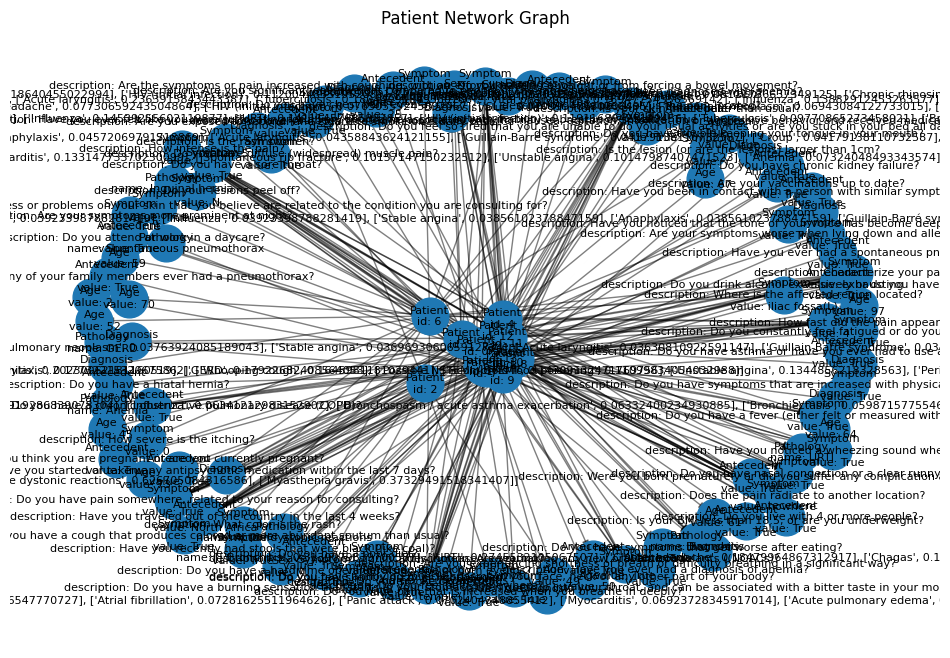

In [ ]:
print("Nodes in the graph:")
print(G.nodes(data=True))

print("\nEdges in the graph:")
print(G.edges(data=True))

# Optional: Visualize the graph (requires matplotlib)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # positions for all nodes

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

# Create labels with additional information
labels = {}
for node in G.nodes(data=True):
    node_id = node[0]
    node_data = node[1]
    # Combine label and properties for display
    label_info = f"{node_data['label']}\n" + "\n".join([f"{k}: {v}" for k, v in node_data.items() if k != 'label'])
    labels[node_id] = label_info

# Draw node labels with the combined information
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title("Patient Network Graph")
plt.axis('off')  # Turn off the axis
plt.show()


In [ ]:
from node2vec import Node2Vec

# Create Node2Vec model
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, p=0.5, q=2, workers=4)

# Fit the model to generate embeddings
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Example: Get the embedding for a specific node
node_id = list(G.nodes())[0]  # Change to the desired node ID
embedding = model.wv[str(node_id)]
print(f"Embedding for node {node_id}: {embedding}")


Computing transition probabilities:   0%|          | 0/118 [00:00<?, ?it/s]

Embedding for node 0: [-0.01227718 -0.01105888  0.01746097 -0.00991139  0.00211835  0.00341829
 -0.00357739 -0.00360616 -0.00693567 -0.02467345  0.00634769 -0.00511603
 -0.01305558  0.01131728  0.007048    0.01667938  0.00363256 -0.00829666
  0.01996375  0.00100933 -0.00197473  0.00839119  0.01070043  0.003111
  0.00779276  0.01062692  0.01312864  0.01896083 -0.00089637 -0.00813848
  0.01972757 -0.01680502  0.0123378   0.00353919  0.00687773  0.00528677
 -0.00098822  0.00976936 -0.00974907  0.01179667  0.01123166  0.01036789
 -0.00305947 -0.02282671  0.01802182  0.00598066 -0.01564157 -0.01731692
 -0.00382909 -0.00032582 -0.0202882  -0.0056786   0.00844479 -0.00723363
  0.00436002 -0.01687017 -0.00105019 -0.01258937 -0.01494305  0.00168013
 -0.01717526 -0.01445476 -0.00258175  0.01414135]


In [ ]:
node_id = list(G.nodes())[1]  # Change to the desired node ID
embedding = model.wv[str(node_id)]
print(f"Embedding for node {node_id}: {embedding}")

Embedding for node 5: [ 0.01043801  0.01285156 -0.00197379  0.00377329 -0.00995124 -0.00962868
  0.01266472 -0.0045283   0.00938633  0.00123172 -0.00250334  0.00495133
 -0.00666951 -0.00255399  0.00231399  0.00885819 -0.00197099  0.00189996
 -0.01200383  0.01534762 -0.01339676  0.01107763  0.00777394 -0.01132721
 -0.00796517 -0.01165847 -0.00795125  0.01111316  0.01499058  0.00317232
  0.0021828   0.0146703  -0.0084068  -0.00266235  0.00504541 -0.01008682
 -0.01520382 -0.01374084  0.0146241   0.00781541 -0.00705638 -0.01253513
  0.00242189  0.00321923 -0.00110065  0.00148863 -0.00789237  0.00696769
  0.00260323  0.01383374 -0.01595023 -0.0088927  -0.0137469   0.00049821
 -0.01177534  0.00717451 -0.00963889 -0.01041308  0.00786766 -0.0118697
  0.00179646 -0.01160273  0.01495622  0.0147426 ]


In [ ]:
# Get embeddings for all nodes
embeddings = {node: model.wv[str(node)] for node in G.nodes()}

# Convert to a pandas DataFrame for easier manipulation
import pandas as pd

embeddings_df = pd.DataFrame(embeddings).T
embeddings_df.columns = [f"dim_{i}" for i in range(embeddings_df.shape[1])]
print(embeddings_df)


        dim_0     dim_1     dim_2     dim_3     dim_4     dim_5     dim_6  \
0   -0.012277 -0.011059  0.017461 -0.009911  0.002118  0.003418 -0.003577   
5    0.010438  0.012852 -0.001974  0.003773 -0.009951 -0.009629  0.012665   
6    0.014532  0.000593 -0.008539 -0.009703  0.010245 -0.008475 -0.004600   
7   -0.005461 -0.003816  0.019829  0.008774 -0.002481 -0.016002 -0.012503   
8    0.000020 -0.003089  0.019921  0.015832 -0.014701  0.002523  0.008800   
..        ...       ...       ...       ...       ...       ...       ...   
116 -0.002267 -0.015464  0.002785  0.004683 -0.015214 -0.006195 -0.003824   
117  0.000874  0.009993  0.009734 -0.000126  0.003920 -0.010272 -0.014824   
105  0.009586 -0.008094  0.005047  0.004194  0.003957  0.012816 -0.011017   
106 -0.012550 -0.009709  0.012334 -0.014316 -0.013372 -0.015594  0.014103   
107 -0.006869 -0.010501 -0.001584 -0.001630  0.011804  0.014055 -0.000679   

        dim_7     dim_8     dim_9  ...    dim_54    dim_55    dim_56  \
0  

In [ ]:
import numpy as np
from node2vec import Node2Vec
import tensorflow as tf
from tensorflow.keras import layers, Model
from scipy.spatial import distance

In [ ]:
def generate_node_embeddings(graph, dimensions=64, walk_length=30, num_walks=200, p=0.5, q=2, workers=4):
    # Create Node2Vec model to generate walks and learn embeddings
    node2vec = Node2Vec(graph, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, p=p, q=q, workers=workers)

    # Fit the model to generate embeddings
    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    # Get embeddings for all nodes in the graph (patients, symptoms, antecedents, etc.)
    embeddings = {node: model.wv[str(node)] for node in graph.nodes()}
    return embeddings, model

In [ ]:
class Sampling(layers.Layer):
    """ Sampling layer for VAE latent space """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def create_vae(latent_dim=64, input_dim=64):
    # Encoder
    encoder_inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(encoder_inputs)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(latent_inputs)
    decoder_outputs = layers.Dense(input_dim, activation='sigmoid')(x)
    decoder = Model(latent_inputs, decoder_outputs, name='decoder')

    # VAE
    vae_outputs = decoder(encoder(encoder_inputs)[2])
    vae = Model(encoder_inputs, vae_outputs, name='vae')

    # Define VAE loss (reconstruction loss + KL divergence)
    reconstruction_loss = tf.reduce_mean(tf.square(encoder_inputs - vae_outputs))  # MSE for reconstruction
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    return vae, encoder, decoder


In [ ]:
def generate_synthetic_patients(num_patients, vae, encoder, decoder, embeddings, graph):
    synthetic_patients = []

    for _ in range(num_patients):
        # Sample a random patient node ID from the embeddings (keys of the dictionary)
        sampled_node = np.random.choice(list(embeddings.keys()))
        real_patient_embedding = embeddings[sampled_node]

        # Generate synthetic patient embedding using VAE
        synthetic_embedding = decoder.predict(encoder.predict(np.expand_dims(real_patient_embedding, axis=0))[2])

        # Map the synthetic embedding back to patient attributes (simplified logic)
        age = np.random.choice([node['a']['value'] for node in graph.run("MATCH (a:Age) RETURN a").data()])
        sex = np.random.choice([node['s']['value'] for node in graph.run("MATCH (s:Sex) RETURN s").data()])
        pathology = np.random.choice([node['p']['name'] for node in graph.run("MATCH (p:Pathology) RETURN p").data()])
        diagnosis = np.random.choice([node['d']['name'] for node in graph.run("MATCH (d:Diagnosis) RETURN d").data()])

        # Generate synthetic symptoms and antecedents
        symptoms = generate_synthetic_symptoms(graph)
        antecedents = generate_synthetic_antecedents(graph)

        synthetic_patient = {
            'AGE': age,
            'SEX': sex,
            'PATHOLOGY': pathology,
            'DIFFERENTIAL_DIAGNOSIS': diagnosis,
            'Translated_Symptoms': symptoms,
            'Translated_Antecedents': antecedents
        }
        synthetic_patients.append(synthetic_patient)

    return synthetic_patients


def generate_synthetic_symptoms(graph):
    """Generate random symptoms from the graph."""
    symptom_nodes = graph.run("MATCH (s:Symptom) RETURN s").data()
    return {node['s']['description']: np.random.choice([node['s']['value'], 'True', 'False']) for node in symptom_nodes}

def generate_synthetic_antecedents(graph):
    """Generate random antecedents from the graph."""
    antecedent_nodes = graph.run("MATCH (a:Antecedent) RETURN a").data()
    return {node['a']['description']: np.random.choice([node['a']['value'], 'True', 'False']) for node in antecedent_nodes}


In [ ]:
from scipy.spatial.distance import jensenshannon

def evaluate_realism(synthetic_patients, real_embeddings):
    for synthetic_patient in synthetic_patients:
        # Assume synthetic_patient['embedding'] holds the synthetic patient's embedding
        synthetic_embedding = synthetic_patient['embedding']

        # Sample a random real patient embedding (select a key first)
        sampled_node = np.random.choice(list(real_embeddings.keys()))
        real_embedding = real_embeddings[sampled_node]

        # Compute a similarity measure between real and synthetic embeddings
        # You can use Jensen-Shannon Divergence, cosine similarity, or others
        js_divergence = jensenshannon(synthetic_embedding, real_embedding)

        # Output the similarity measure for debugging or validation
        print(f"Jensen-Shannon Divergence between synthetic and real patient: {js_divergence}")


def patient_data_to_embedding(patient_data):
    # Convert the patient data back to an embedding (this would depend on the graph structure)
    return np.random.random(64)  # Dummy example


In [ ]:
embeddings, node2vec_model = generate_node_embeddings(G)

# Step 2: Create VAE
latent_dim = 64
vae, encoder, decoder = create_vae(latent_dim=latent_dim, input_dim=latent_dim)
vae.compile(optimizer='adam')

# Step 3: Generate synthetic patients with symptoms and antecedents
num_synthetic_patients = 10
synthetic_patients = generate_synthetic_patients(num_synthetic_patients, vae, encoder, decoder, embeddings, graph)

# Step 4: Evaluate the realism of synthetic patients
# evaluate_realism(synthetic_patients, embeddings)

# Print the generated synthetic patient records
for patient in synthetic_patients:
    print(patient)

Computing transition probabilities:   0%|          | 0/118 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step
{'AGE': 59, 'SEX': 'M', 'PATHOLOGY': 'Acute dystonic reactions', 'DIFFERENTIAL_DIAGNOSIS': "[['Unstable angina', 0.1069190530542801], ['Spontaneous pneumothorax', 0.10623392228338295], ['Possible NSTEMI / STEMI', 0.09127403180165326], ['Pulmonary embolism', 0.09069042040148312], ['Stable angina', 0.08903416547770727], ['Atrial fibrillation', 0.07281625511964626], ['Panic attack', 0.0702404348855412], ['Myocarditis', 0.06923728345917014], ['Acute pulmonary edema', 0.06642348093088675], ['Pericarditis', 0.0659776259105425], ['Guillain-Barré syndrome', 0.06277737180113709], ['Acute dystonic reactions', 0.04420847687451707], ['Sarcoidosis', 0.03620309385675092], ['Scombroid food poisoning', 0.027964384143301362]]", 'Translated_Symptoms': {'Have you recently had stools that were black (like coal)?': 'False', 'Do you have a burning sensation that starts in your stomach then goes up into your throat, and can be associated with a bitter taste